In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
def show_original_img(img):
    # Convert NumPy array to PIL Image
    img_pil = Image.fromarray(np.uint8(img))

    # Display the image using matplotlib
    plt.title("Original Image")
    plt.imshow(img_pil, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()

In [3]:
def show_image_with_edges(img, upper_edge_row_vals, lower_edge_row_vals, interval):
    # Convert NumPy array to PIL Image
    img_pil = Image.fromarray(np.uint8(img))

    # Create a copy of the image to avoid modifying the original
    img_with_edges = img_pil.copy()

    # Calculate x and y coordinates for the points
    x_coords_up = np.arange(0, len(upper_edge_row_vals) * interval, interval)
    y_coords_up = upper_edge_row_vals
    x_coords_low = np.arange(0, len(lower_edge_row_vals) * interval, interval)
    y_coords_low = lower_edge_row_vals

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image on the axis
    ax.set_title("Image with edges")  # Set the title for the axis
    ax.imshow(img_with_edges, cmap='gray')

    # Plot the points on the image in red color
    ax.scatter(x_coords_up, y_coords_up, color='red', s=2)  # 's' is the marker size
    ax.scatter(x_coords_low, y_coords_low, color='yellow', s=2)  # 's' is the marker size

    # Hide axes
    ax.axis('off')

    # Show the plot
    plt.show()

## Specify directory for image array creation

In [4]:
def joint_edges_values(img, interval, image_size=224):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint8:
        raise ValueError("Image must be a NumPy array of type uint8")
    if interval <= 0 or not isinstance(interval, int):
        raise ValueError("Interval must be a positive integer")

    # col_indices hold indices of columns at specific intervals along image row/width
    col_indices = np.arange(0, image_size, interval)
    # initialize upper row values to 1/3rd of image height
    upper_edge_rvals = np.full(len(col_indices), int(image_size/4), dtype=np.uint8)
    # initialize lower row values to 3/4th of image height
    lower_edge_rvals = np.full(len(col_indices), int(image_size*3/4), dtype=np.uint8)

    for i, c in enumerate(col_indices):
        up_start, low_start = int(image_size/4), int(image_size*3/4)
        col = img[:, c]
        col = col[up_start:low_start]
        col_max, col_min, col_std = col.max(), col.min(), col.std()
        col_thresh = col_min + int(col_std) # improvement
        
        up_flag = low_flag = False

        upper_r, lower_r = up_start, low_start
        while upper_r < lower_r:
            if not up_flag:
                # need to improve
                if img[upper_r, c] < col_thresh and img[upper_r+1, c] < col_thresh and img[upper_r+2, c] < col_thresh:
                    upper_edge_rvals[i] = upper_r
                    up_flag = True
                else:
                    upper_r += 1
                
            if not low_flag:
                if img[lower_r, c] < col_thresh and img[lower_r-1, c] < col_thresh and img[lower_r-2, c] < col_thresh:
                    lower_edge_rvals[i] = lower_r
                    low_flag = True
                else:
                    lower_r -= 1
            
            if up_flag and low_flag:
                break
    
    max_dist = int(up_start/2)
    for i in range(len(col_indices)):
        if (lower_edge_rvals[i] - upper_edge_rvals[i]) > max_dist:
            upper_edge_rvals[i] = lower_edge_rvals[i]
        
    return upper_edge_rvals, lower_edge_rvals

## Specify image path 

In [5]:
img_path = 'dataset/1/9275309R.png'


img = Image.open(img_path)
img = np.array(img)

# Main Program to show original and edge-detected image

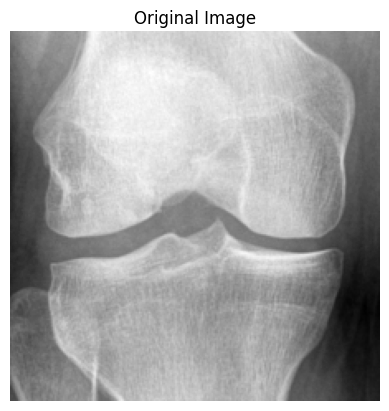

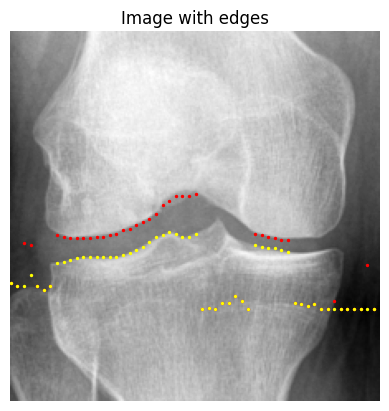



Joint space in pixels taken at interval of 4 pixels along image width

Total points = 56
[ 0  0 26 18  0  0  0 17 15 13 12 11 11 12 12 13 14 15 15 15 15 14 14 18
 19 23 25 25 24  0  0  0  0  0  0  0  0  7  7  7  6  6  7  0  0  0  0  0
  0  5  0  0  0  0 27  0]


In [6]:
## ------------   Main program  --------------

# show original image
show_original_img(img)

interval = 4
# calculate upper and lower edges for this image
upper_edge_row_vals, lower_edge_row_vals = joint_edges_values(img, interval, img[0].size)

joint_space_pixel_gap = lower_edge_row_vals - upper_edge_row_vals
# Change values greater than 40 to 223
# joint_space_pixel_gap = np.where(joint_space_pixel_gap > 40, 223, joint_space_pixel_gap) 


# show the image with edges
show_image_with_edges(img, upper_edge_row_vals, lower_edge_row_vals, interval)


# show pixel gaps at specific interval along image-width
print(f"\n\nJoint space in pixels taken at interval of {interval} pixels along image width\n")
print(f'Total points = {int(224/interval)}')
print(joint_space_pixel_gap)

In [7]:
def make_image_array(image_dir):
    image_list = []

    # Iterate through each folder
    for folder in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # List all png files in the folder
            for file in os.listdir(folder_path):
                if file.endswith('.png'):
                    file_path = os.path.join(folder_path, file)

                    # Open the image and append to the list
                    image = Image.open(file_path)
                    image_list.append(image)

    # Convert list of images to a numpy array
    image_array = np.array([np.array(img) for img in image_list])

    # Now image_array contains all the images
    print("Image array created. Shape:  ", image_array.shape)
    
    return image_array

# Csv File Generation with ~1000 random sample images

In [8]:
def generate_csv(image_array, num_samples):
    # Specify the CSV file path
    js_csv = 'joint_spaces.csv'

    # Initialize an empty DataFrame with columns
    columns = ['img_idx'] + [f'c{i}' for i in range(56)]
    df = pd.DataFrame(columns=columns)

    # Randomly select num_sample indices
    random_indices = random.sample(range(len(image_array)), num_samples)
    random_indices.sort()

    # Add rows to the DataFrame
    img_rows = []

    for idx in random_indices:
        img = image_array[idx]
        upper_edge_row_vals, lower_edge_row_vals = joint_edges_values(img, 4, 224)
        joint_space_pixel_gap = lower_edge_row_vals - upper_edge_row_vals
        # Change values greater than 40 to 223
        joint_space_pixel_gap = np.where(joint_space_pixel_gap > 40, 223, joint_space_pixel_gap)

        img_rows.append([f'im{idx}'] + list(joint_space_pixel_gap))

    # Convert img_rows to a DataFrame
    js_data = pd.DataFrame(img_rows, columns=columns)

    # Concatenate the existing DataFrame and the new data
    df = pd.concat([df, js_data], ignore_index=True)

    # Save the updated DataFrame to the CSV file
    df.to_csv(js_csv, index=False)

In [9]:
image_array = make_image_array('dataset')

Image array created. Shape:   (826, 224, 224)


In [10]:
generate_csv(image_array, 100)